In [4]:
# Classification Project: Decision Trees, Naive Bayes, and SVM
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Classification Analysis

This notebook covers classification using Decision Trees (ID3, CART), Naive Bayes, and Support Vector Machine (SVM). Model evaluation and comparison are included for each method.

## 1. Data Loading, Preprocessing, and Exploration

We will load the dataset, preprocess it to optimize classification performance, and visualize key aspects. Preprocessing includes handling missing values, encoding categorical variables, and scaling features. These steps are chosen to ensure models receive clean, numerical, and standardized data, which improves accuracy and comparability.

Loading dataset...
Shape: (999999, 17)
Columns: ['MovieID', 'Title', 'Genre', 'ReleaseYear', 'ReleaseDate', 'Country', 'BudgetUSD', 'US_BoxOfficeUSD', 'Global_BoxOfficeUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT', 'Director', 'LeadActor']


,MovieID,Title,Genre,ReleaseYear,ReleaseDate,Country,BudgetUSD,US_BoxOfficeUSD,Global_BoxOfficeUSD,Opening_Day_SalesUSD,One_Week_SalesUSD,IMDbRating,RottenTomatoesScore,NumVotesIMDb,NumVotesRT,Director,LeadActor
0,1,Might toward capital,Comedy,2003,28-09-2003,China,6577427.79,6613685.82,15472035.66,1778530.85,3034053.32,6.2,58,7865,10596,Kristina Moore,Brian Mccormick
1,2,He however experience,Comedy,1988,14-02-1988,USA,1883810.10,1930949.15,3637731.12,247115.74,831828.84,5.2,44,1708,220,Benjamin Hudson,Ashley Pena
2,3,Star responsibility politics,Comedy,1971,02-11-1971,USA,2468079.29,4186694.69,7165111.24,878453.95,2171405.93,5.5,55,4678,7805,Kayla Young,Alexander Haley


Chosen column for creating/using target: Genre
Reason: low-cardinality categorical column: Genre
Using categorical column 'Genre' as target.


C:\Users\julen.anda\AppData\Local\Temp\ipykernel_13736\1808891206.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):


Final feature shape: (999999, 16)
Target distribution:
target
Drama          250018
Comedy         199832
Action         150131
Thriller       100071
Romance        100021
Horror         100010
Documentary     50114
Sci-Fi          49802
Name: count, dtype: int64


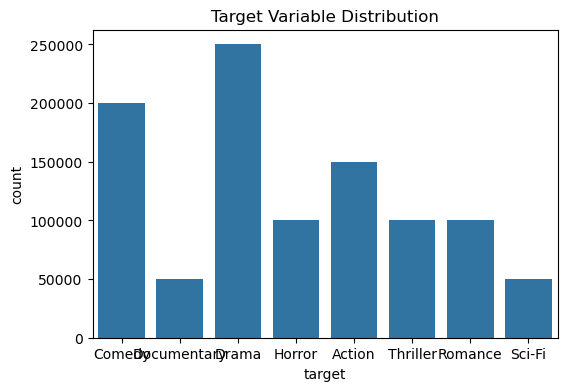

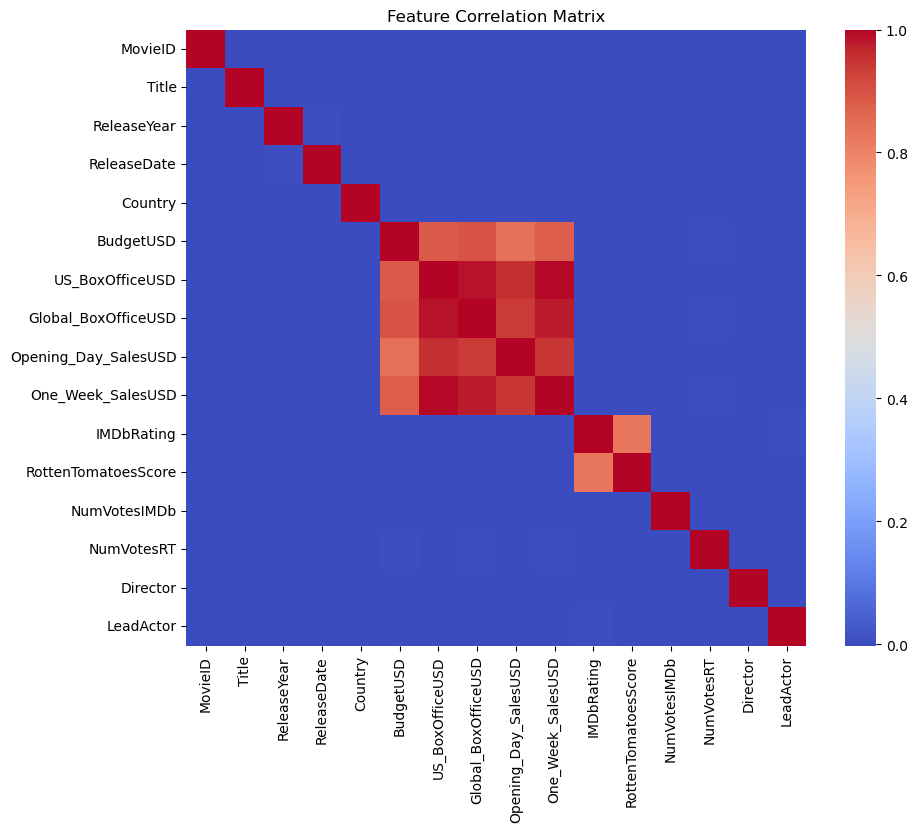

Saved chosen_target_column = Genre


In [8]:
# Read the data
# The notebook will choose a suitable target automatically using heuristics
print('Loading dataset...')
df = pd.read_csv('./data/movies_dataset.csv')
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# Quick preview
display(df.head(3))

# Heuristic to select a target column:
# 1) Prefer low-cardinality categorical columns (excluding obvious text/id columns)
# 2) Else prefer common numeric candidates: vote_average, rating, revenue, popularity
# 3) Else pick the first numeric column (not an id)
ignore_text_cols = {'title','overview','description','id','movie_id','imdb_id'}

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
low_card_cols = [c for c in cat_cols if c not in ignore_text_cols and df[c].nunique()>=2 and df[c].nunique()<=10]

if low_card_cols:
    chosen = low_card_cols[0]
    reason = f"low-cardinality categorical column: {chosen}"
else:
    preferred = ['vote_average','rating','revenue','popularity']
    chosen = None
    for p in preferred:
        if p in df.columns:
            chosen = p
            break
    if chosen is None:
        num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if 'id' not in c.lower()]
        if num_cols:
            chosen = num_cols[0]
        else:
            raise ValueError('No suitable target column found automatically. Please pick one manually.')
    reason = f"numeric candidate column: {chosen}"

print('Chosen column for creating/using target:', chosen)
print('Reason:', reason)

# Create a unified 'target' column for classification
if np.issubdtype(df[chosen].dtype, np.number):
    # If numeric with many unique values, bin into 3 quantile-based classes (low/medium/high)
    if df[chosen].nunique() > 10:
        df['target'] = pd.qcut(df[chosen], q=3, labels=['low','medium','high'])
        print(f"Binned numeric column '{chosen}' into 3 classes (low/medium/high).")
    else:
        # Treat small-unique numeric as categorical
        df['target'] = df[chosen].astype(str)
        print(f"Converted numeric column '{chosen}' to categorical string labels.")
else:
    # Already categorical/text: use as-is
    df['target'] = df[chosen].astype(str)
    print(f"Using categorical column '{chosen}' as target.")

# Drop rows with missing target after transformation
df = df.dropna(subset=['target']).copy()

# Fill missing values for features (but avoid filling the columns used for target creation if they should be preserved)
for col in df.columns:
    if col == 'target':
        continue
    if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    else:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

# Drop obvious free-text columns from features to avoid high-dimensional noise
drop_text = [c for c in ['title','overview','description','cast','crew','homepage'] if c in df.columns]

# Build feature matrix X and target y
to_drop = ['target']
if chosen in df.columns and chosen != 'target':
    to_drop.append(chosen)
to_drop += drop_text

X = df.drop(columns=[c for c in to_drop if c in df.columns])
y = df['target']

print('Final feature shape:', X.shape)
print('Target distribution:')
print(y.value_counts())

# Encode categorical features
label_encoders = {}
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object','category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Encode target labels
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, random_state=42)

# Visualizations: target distribution and feature correlation (on encoded/scaled data)
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Target Variable Distribution')
plt.show()

plt.figure(figsize=(10,8))
# compute correlation on features (pandas DataFrame for column names)
feat_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)
sns.heatmap(feat_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Save chosen target info to use later
chosen_target_column = chosen
print('Saved chosen_target_column =', chosen_target_column)

## 3. Decision Trees (ID3 & CART)

We will train and evaluate Decision Tree classifiers using both ID3 (entropy) and CART (gini) criteria.

In [9]:


# ID3 (criterion='entropy')
dt_id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_id3.fit(X_train, y_train)
y_pred_id3 = dt_id3.predict(X_test)

print('ID3 (Entropy) Decision Tree Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_id3))
print(classification_report(y_test, y_pred_id3))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_id3))



ID3 (Entropy) Decision Tree Results:
Accuracy: 0.158865
              precision    recall  f1-score   support

           0       0.15      0.15      0.15     30231
           1       0.20      0.20      0.20     40014
           2       0.05      0.05      0.05     10110
           3       0.25      0.24      0.25     49769
           4       0.10      0.10      0.10     20227
           5       0.10      0.10      0.10     19785
           6       0.05      0.05      0.05      9825
           7       0.10      0.10      0.10     20039

    accuracy                           0.16    200000
   macro avg       0.13      0.13      0.13    200000
weighted avg       0.16      0.16      0.16    200000

Confusion Matrix:
 [[ 4553  5917  1601  7447  3023  3063  1581  3046]
 [ 5975  7906  2025  9789  3986  4131  2109  4093]
 [ 1486  2040   487  2473  1032  1025   543  1024]
 [ 7405  9816  2577 12150  5118  5137  2598  4968]
 [ 3012  3948  1040  5009  2065  2090  1095  1968]
 [ 2997  3917  1003

In [10]:
# CART (criterion='gini')
dt_cart = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_cart.fit(X_train, y_train)
y_pred_cart = dt_cart.predict(X_test)

print('CART (Gini) Decision Tree Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_cart))
print(classification_report(y_test, y_pred_cart))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_cart))

CART (Gini) Decision Tree Results:
Accuracy: 0.158345
              precision    recall  f1-score   support

           0       0.15      0.15      0.15     30231
           1       0.20      0.20      0.20     40014
           2       0.05      0.05      0.05     10110
           3       0.25      0.25      0.25     49769
           4       0.10      0.10      0.10     20227
           5       0.10      0.10      0.10     19785
           6       0.05      0.05      0.05      9825
           7       0.10      0.10      0.10     20039

    accuracy                           0.16    200000
   macro avg       0.12      0.12      0.12    200000
weighted avg       0.16      0.16      0.16    200000

Confusion Matrix:
 [[ 4578  6105  1542  7421  3052  3025  1514  2994]
 [ 6062  7826  2059  9967  4084  4015  1959  4042]
 [ 1500  2013   538  2464  1048  1000   522  1025]
 [ 7458  9725  2550 12223  5013  5154  2554  5092]
 [ 3055  4088  1056  4942  2027  2020   993  2046]
 [ 2854  3972  1014  

## 4. Naive Bayes

Train and evaluate a Naive Bayes classifier.

In [11]:

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print('Naive Bayes Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_nb))

Naive Bayes Results:
Accuracy: 0.244365
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     30231
           1       0.21      0.01      0.02     40014
           2       0.05      0.02      0.03     10110
           3       0.25      0.97      0.40     49769
           4       0.10      0.00      0.00     20227
           5       0.12      0.00      0.01     19785
           6       0.00      0.00      0.00      9825
           7       0.00      0.00      0.00     20039

    accuracy                           0.24    200000
   macro avg       0.09      0.13      0.06    200000
weighted avg       0.13      0.24      0.10    200000

Confusion Matrix:
 [[    0   275   604 29264     7    81     0     0]
 [    0   381   800 38728     7    98     0     0]
 [    0    93   184  9813     3    17     0     0]
 [    0   441   952 48245    12   119     0     0]
 [    0   193   419 19549     4    62     0     0]
 [    0   174   417 19130     5    

c:\Users\julen.anda\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julen.anda\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julen.anda\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

## 5. Support Vector Machine (SVM)

Train and evaluate a Support Vector Machine classifier.

In [ ]:


svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print('Support Vector Machine Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))

## 6. Model Comparison

Compare the performance of all classifiers using accuracy and classification metrics.

In [ ]:
# Compare model accuracies
results = {
    'ID3 Decision Tree': accuracy_score(y_test, y_pred_id3),
    'CART Decision Tree': accuracy_score(y_test, y_pred_cart),
    'Naive Bayes': accuracy_score(y_test, y_pred_nb),
    #'SVM': accuracy_score(y_test, y_pred_svm)
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print(results_df)

# Bar plot for comparison
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Classifier Accuracy Comparison')
plt.ylim(0,1)
plt.show()